In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.utils import multi_gpu_model

In [3]:
import tensorflow as tf

In [4]:
import os
import sys
import cv2
from matplotlib import pyplot as plt
import time

In [5]:
main_dir = os.getcwd()

In [6]:
DATASET_PATH = main_dir + "/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
SINGLE_TEST_PATH = main_dir + "/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001"
BATCH_SIZE = 4
EPOCHS = 3
MODEL_PATH = main_dir + "/model.hdf5"

In [7]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(DATASET_PATH)):
        directory_path = join(DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [8]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=False)
    seq.save(MODEL_PATH)
    return seq

In [9]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(SINGLE_TEST_PATH)):
        if str(join(SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [10]:
def evaluate():
    model = get_model(False)
    print("got model")
    test = get_single_test()
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=BATCH_SIZE)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

got model
got test


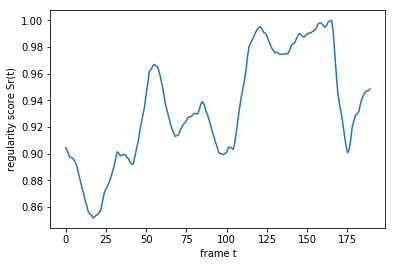

In [13]:
#evaluate()

In [11]:
single_test = get_single_test()

In [12]:
single_test.shape

(200, 256, 256, 1)

In [12]:
single_test[:,:,:,0].shape

(200, 256, 256)

In [10]:
%matplotlib inline

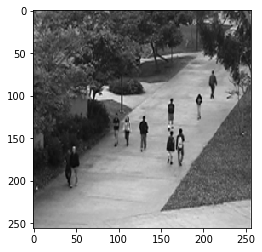

In [37]:
plt.imshow(single_test[:,:,:,0][140], cmap='gray')
plt.show()

In [12]:
model = get_model(False)

In [13]:
parallel_model = multi_gpu_model(model)

In [15]:
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_1_input (Input (None, 10, 256, 256, 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 10, 256, 256, 0           time_distributed_1_input[0][0]   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10, 256, 256, 0           time_distributed_1_input[0][0]   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 10, 256, 256, 0           time_distributed_1_input[0][0]   
__________________________________________________________________________________________________
lambda_4 (

In [14]:
##All possible sequences
num_sequences = single_test.shape[0] - 10
sequences = np.zeros((num_sequences, 10, 256, 256, 1))
# apply the sliding window technique to get the sequences
for i in range(0, num_sequences):
    clip = np.zeros((10, 256, 256, 1))
    for j in range(0, 10):
        clip[j] = single_test[i + j, :, :, :]
    sequences[i] = clip

In [20]:
sequences.shape

(190, 10, 256, 256, 1)

In [42]:
one_sequence = sequences[10:11,:,:,:]

In [43]:
start = time.time()
reconstructed_sequences = model.predict(one_sequence,batch_size=BATCH_SIZE)
end = time.time() - start
print(end, 'secs')

1.2637946605682373 secs


In [44]:
sequence_reconstruction_cost = np.array([np.linalg.norm(np.subtract(one_sequence[i],reconstructed_sequences[i])) for i in range(0,1)])

In [45]:
sequence_reconstruction_cost

array([ 24.56578652])

In [ ]:
##All sequences
start = time.time()
reconstructed_sequences = parallel_model.predict(sequences,batch_size=BATCH_SIZE)
end = time.time() - start
print(end, 'secs')

In [59]:
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,num_sequences)])


In [1]:
sequences_reconstruction_cost

NameError: name 'sequences_reconstruction_cost' is not defined

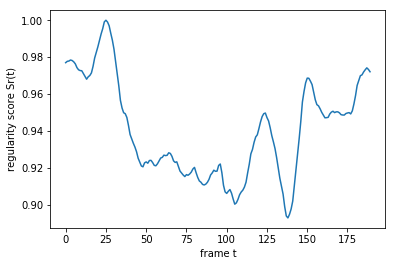

In [61]:
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()